In [ ]:

from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Beatles"
!ls
basepath = '.'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Beatles
Beatle_recognizer.h5  beatles_recognizer.keras	george	john  paul  ringo


In [ ]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import models, optimizers, layers
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score, recall_score
from google.colab import files
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from skimage import exposure

In [ ]:
john_folder = os.path.join(basepath, 'john')
paul_folder = os.path.join(basepath, 'paul')
george_folder = os.path.join(basepath, 'george')
ringo_folder = os.path.join(basepath, 'ringo')

Train class counts: (array([0, 1, 2, 3]), array([279, 281, 277, 286]))
Val class counts: (array([0, 1, 2, 3]), array([120, 121, 118, 123]))


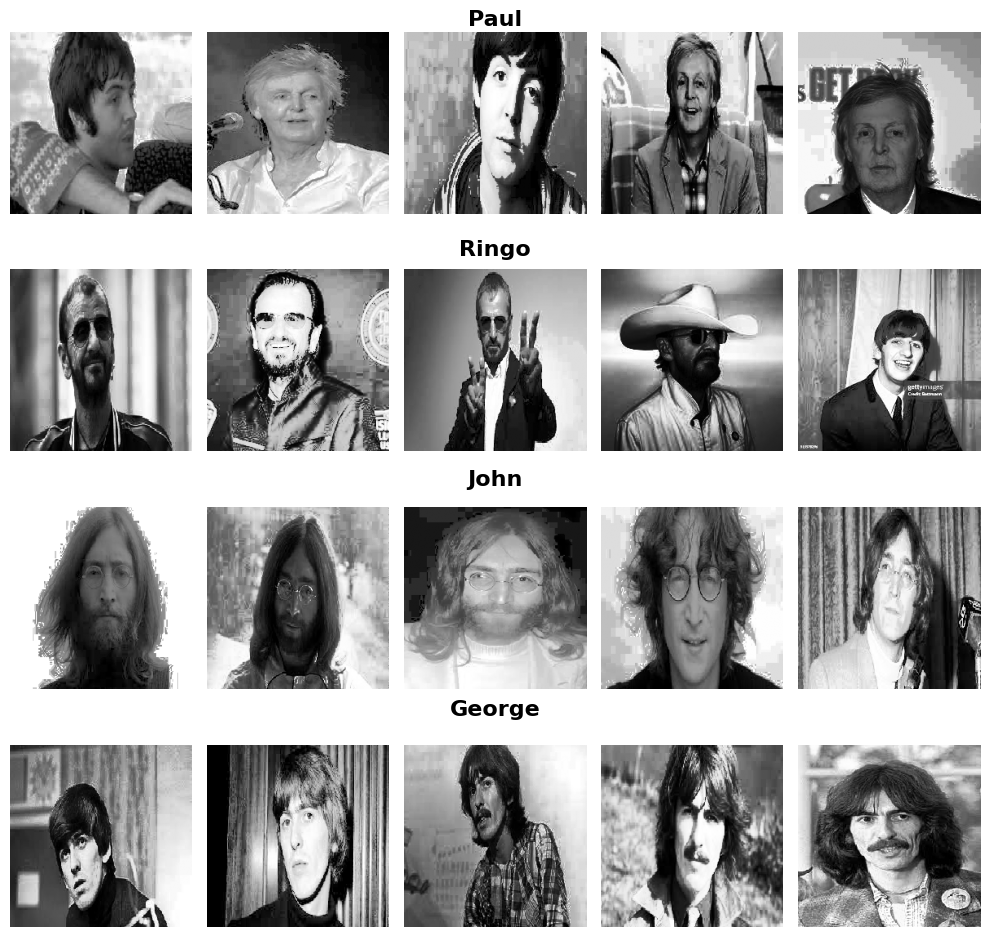

In [ ]:
image_size = (224, 224)

label_map = {'john': 0, 'paul': 1, 'george': 2, 'ringo': 3}

def preprocess(folder_name, apply_equalization=False):
    images = []
    for filename in os.listdir(folder_name):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
            img_path = os.path.join(folder_name, filename)
            img = load_img(img_path, target_size=image_size, color_mode='grayscale')
            img_array = img_to_array(img) / 255.0

            if apply_equalization:
                img_array = exposure.equalize_hist(img_array.squeeze())
                img_array = np.expand_dims(img_array, axis=-1)

            images.append(img_array)
    return np.array(images)


john_images   = preprocess(os.path.join(basepath, 'john'), apply_equalization=True)
paul_images   = preprocess(os.path.join(basepath, 'paul'), apply_equalization=True)
george_images = preprocess(os.path.join(basepath, 'george'), apply_equalization=True)
ringo_images  = preprocess(os.path.join(basepath, 'ringo'), apply_equalization=True)

X = np.concatenate([john_images, paul_images, george_images, ringo_images], axis=0)
y = np.array(
    [label_map['john']] * len(john_images) +
    [label_map['paul']] * len(paul_images) +
    [label_map['george']] * len(george_images) +
    [label_map['ringo']] * len(ringo_images)
)

X, y = shuffle(X, y, random_state=42)

X_train, X_val, y_train_labels, y_val_labels = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

y_train = to_categorical(y_train_labels, num_classes=4)
y_val = to_categorical(y_val_labels, num_classes=4)

print("Train class counts:", np.unique(y_train_labels, return_counts=True))
print("Val class counts:", np.unique(y_val_labels, return_counts=True))

f, axarr = plt.subplots(4, 5, figsize=(10, 10))
image_sets = [paul_images, ringo_images, john_images, george_images]
beatles = ['Paul', 'Ringo', 'John', 'George']

for row in range(4):
    for col in range(5):
        axarr[row][col].imshow(image_sets[row][col].squeeze(), cmap='gray')
        axarr[row][col].axis('off')

for row, name in enumerate(beatles):
    ypos = 0.96 - row * 0.23
    f.text(0.5, ypos, name, ha='center', va='center', fontsize=16, weight='bold')

plt.tight_layout()
plt.show()

X_train shape: (1123, 224, 224, 1)
y_train shape: (1123, 4)


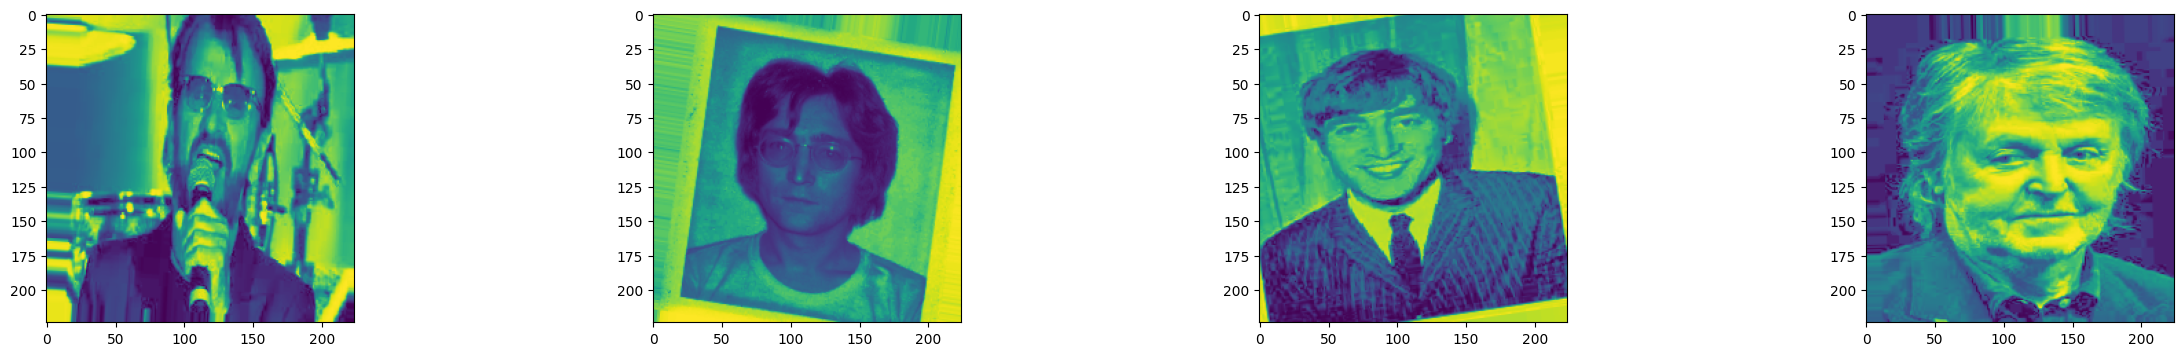

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train, y_train = shuffle(X_train, y_train, random_state=42)

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=24, shuffle=True)

images = next(train_generator)[0]

f, axarr = plt.subplots(1, 4, figsize=(30, 4))

for i in range(4) :
  axarr[i].imshow(images[i])

In [95]:
def build_model(input_shape=(224, 224, 1), num_classes=4):
    model = models.Sequential()

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

model = build_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 224, 224, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,214,660 (4.63 MB)

 Trainable params: 1,212,868 (4.63 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
"""def build_model(input_shape=(224, 224, 1), num_classes=4):
  model = models.Sequential()

  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(num_classes, activation='softmax'))

  return model

model = build_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()"""

"def build_model(input_shape=(224, 224, 1), num_classes=4):\n  model = models.Sequential()\n\n  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))\n  model.add(layers.MaxPooling2D((2, 2)))\n\n  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))\n  model.add(layers.MaxPooling2D((2, 2)))\n\n  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))\n  model.add(layers.MaxPooling2D((2, 2)))\n\n  model.add(layers.Flatten())\n  model.add(layers.Dense(128, activation='relu'))\n  model.add(layers.Dropout(0.5))\n  model.add(layers.Dense(num_classes, activation='softmax'))\n\n  return model\n\nmodel = build_model()\nmodel.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])\nmodel.summary()"

In [ ]:
"""vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_base.layers:
    layer.trainable = False

x = vgg_base.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(4, activation='softmax')(x)

model = Model(inputs=vgg_base.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()"""

"vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))\n\nfor layer in vgg_base.layers:\n    layer.trainable = False\n\nx = vgg_base.output\nx = layers.Flatten()(x)\nx = layers.Dense(256, activation='relu')(x)\nx = layers.Dropout(0.5)(x)\noutput = layers.Dense(4, activation='softmax')(x)\n\nmodel = Model(inputs=vgg_base.input, outputs=output)\n\nmodel.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])\n\nmodel.summary()"

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step
 — val_f1: 0.0000 — val_recall: 0.0000
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 485ms/step - accuracy: 0.2605 - loss: 1.5684 - val_accuracy: 0.2510 - val_loss: 1.3966
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
 — val_f1: 0.0000 — val_recall: 0.0000
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 278ms/step - accuracy: 0.2898 - loss: 1.4136 - val_accuracy: 0.2510 - val_loss: 1.4147
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
 — val_f1: 0.0000 — val_recall: 0.0000
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 278ms/step - accuracy: 0.3088 - loss: 1.3785 - val_accuracy: 0.2510 - val_loss: 1.3909
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
 — val_f1: 0.0000 — val_recall: 0.0000
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - accuracy: 0.3256 - loss: 1.3501 - val_accuracy: 0.2469 - val_loss: 1.4718
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
 — val_f1: 0.0000 — val_recall: 0.0000
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 285ms/step - accuracy: 0.3441 - loss: 1.3431 -

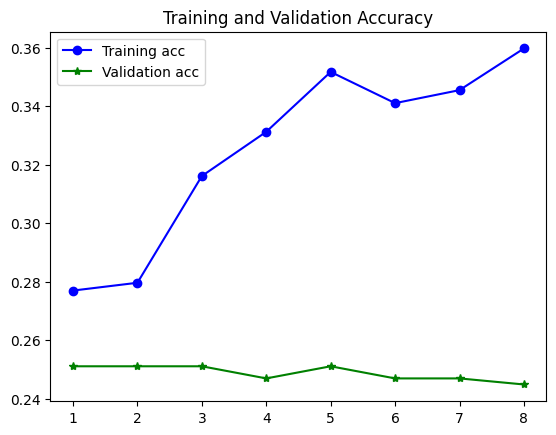

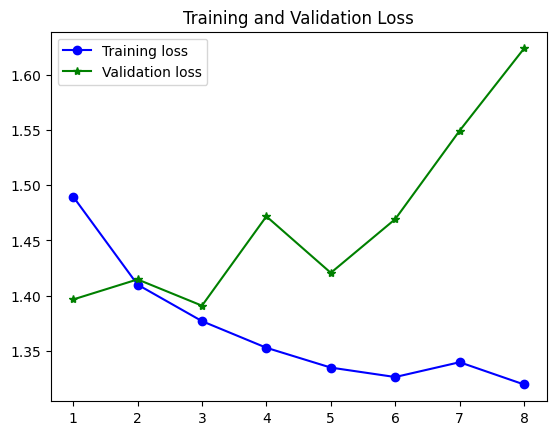

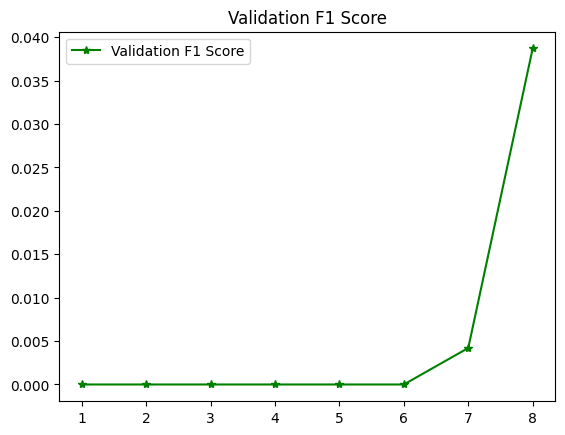

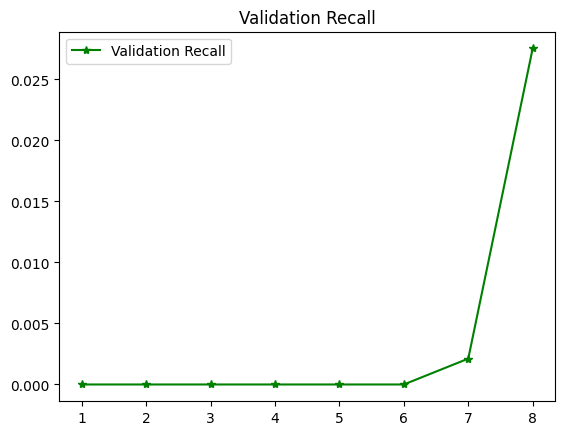

In [96]:
class MetricsCallback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.f1s = []
        self.recalls = []

    def on_epoch_end(self, epoch, logs=None):
        val_pred = (self.model.predict(self.X_val) > 0.5).astype(int)
        recall = recall_score(self.y_val, val_pred, average='macro')
        f1 = f1_score(self.y_val, val_pred, average='macro')

        self.recalls.append(recall)
        self.f1s.append(f1)

        print(f" — val_f1: {f1:.4f} — val_recall: {recall:.4f}")

metrics_callback = MetricsCallback(X_val, y_val)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=(X_val, y_val),
    epochs=15,
    callbacks=[early_stop, metrics_callback]
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_f1 = metrics_callback.f1s
val_recall = metrics_callback.recalls

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'g*-', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'g*-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

plt.plot(epochs, val_f1, 'g*-', label='Validation F1 Score')
plt.title('Validation F1 Score')
plt.legend()
plt.figure()

plt.plot(epochs, val_recall, 'g*-', label='Validation Recall')
plt.title('Validation Recall')
plt.legend()

plt.show()


In [ ]:
class_names = ['John', 'Paul', 'George', 'Ringo']

def plot_image(i, predictions_array, true_label, img):
    true_label_idx = np.argmax(true_label[i])
    predicted_label_idx = np.argmax(predictions_array)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[i])

    color = 'blue' if predicted_label_idx == true_label_idx else 'red'
    plt.xlabel("{} {:2.0f}% (True: {})".format(
        class_names[predicted_label_idx],
        100*np.max(predictions_array),
        class_names[true_label_idx]),
        color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label_idx = np.argmax(true_label[i])

    plt.grid(False)
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks([])
    thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    thisplot[true_label_idx].set_color('blue')
    thisplot[np.argmax(predictions_array)].set_color('red')



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


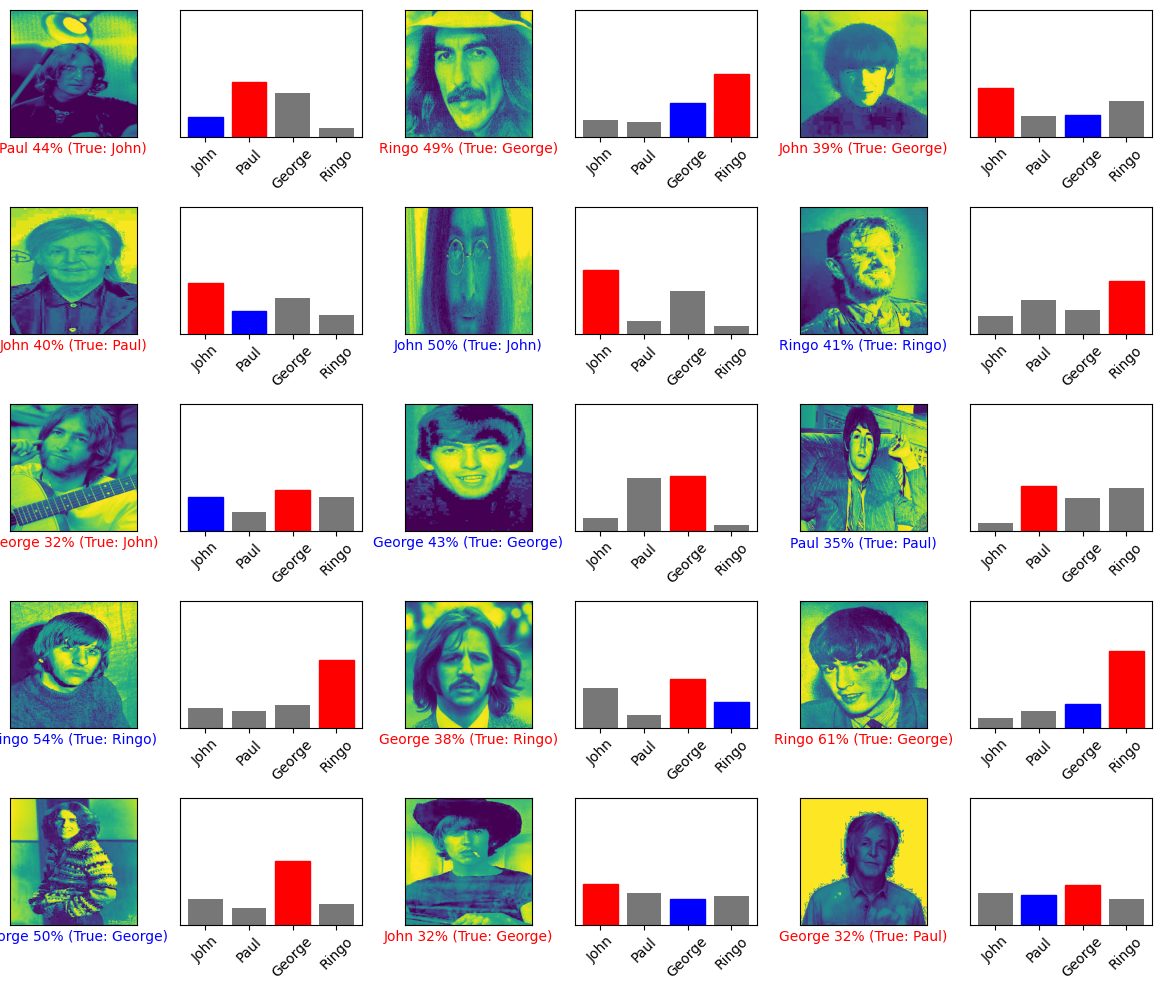

In [93]:
X_val,y_val = shuffle(X_val,y_val)

predictions = model.predict(X_val)

num_rows = 5
num_cols = 3
num_images = num_rows * num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], y_val, X_val)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_val)
plt.tight_layout()
plt.show()


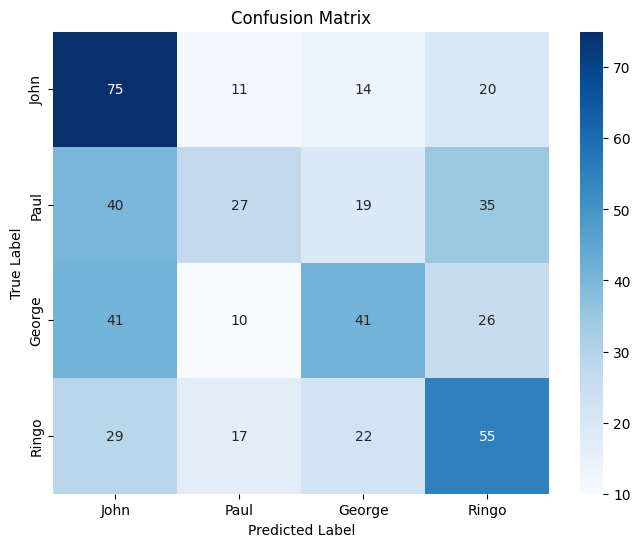

In [97]:
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ['John', 'Paul', 'George', 'Ringo']
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
"""model.save('beatles_recognizer.keras')
files.download('beatles_recognizer.keras')"""

"model.save('beatles_recognizer.keras')\nfiles.download('beatles_recognizer.keras')"